In [3]:
# Reading the input data
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [4]:
!pip install plyfile

In [5]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
from plyfile import PlyData

def load_ply(path, with_faces=False, with_color=False):
    ply_data = PlyData.read(path)
    points = ply_data['vertex']
    points = np.vstack([points['x'], points['y'], points['z']]).T
    ret_val = [points]

    if with_faces:
        faces = np.vstack(ply_data['face']['vertex_indices'])
        ret_val.append(faces)

    if with_color:
        r = np.vstack(ply_data['vertex']['red'])
        g = np.vstack(ply_data['vertex']['green'])
        b = np.vstack(ply_data['vertex']['blue'])
        color = np.hstack((r, g, b))
        ret_val.append(color)

    if len(ret_val) == 1:  # Unwrap the list
        ret_val = ret_val[0]

    return ret_val

def write_ply(points, output_path, faces=None, colors=None):
    with open(output_path, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write('element vertex {}\n'.format(len(points)))
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')

        if colors is not None:
            f.write('property uchar red\n')
            f.write('property uchar green\n')
            f.write('property uchar blue\n')

        if faces is not None:
            f.write('element face {}\n'.format(len(faces)))
            f.write('property list uchar int vertex_index\n')
            f.write('end_header\n')

            for point in points:
                f.write('{} {} {}\n'.format(point[0], point[1], point[2]))

            for face in faces:
                f.write('3 {} {} {}\n'.format(face[0], face[1], face[2]))
        else:
            f.write('end_header\n')

            for point in points:
                f.write('{} {} {}\n'.format(point[0], point[1], point[2]))


    # print("PLY file saved to:", output_path)



class PointCloudDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_paths = self._get_file_paths()

    def _get_file_paths(self):
        file_paths = []
        for root, dirs, files in os.walk(self.root_dir):
            for dir in dirs:
                subdir_path = os.path.join(root, dir)
                for file in os.listdir(subdir_path):
                    if file.endswith(".ply"):
                        file_paths.append(os.path.join(subdir_path, file))
        return file_paths
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        ply_data = load_ply(self.file_paths[idx])
        points = torch.tensor(ply_data, dtype=torch.float32)
        return points


In [6]:
import numpy as np
import os
import random
import shutil
from pathlib import Path

def remove_points(pc_org, del_ratio):
    pc = pc_org[:, :3]
    seed_idx = random.randint(0, pc_org.shape[0] - 1)
    seed = pc[seed_idx]

    diff = pc - seed
    dist_sq = np.sum(diff * diff, axis=1)
    sort_idx = np.argsort(dist_sq)

    remove_idx = sort_idx[:int(pc_org.shape[0] * del_ratio / 100)]
    pc_removed = np.delete(pc, remove_idx, axis=0)

    return pc_removed

# Function to split data into train and test sets
def split_data(org_root, del_ratio = 50, split_ratio = 70):
    new_root = org_root + '_pointsremoved'
    train_root = os.path.join(new_root, 'train', str(del_ratio))
    test_root = os.path.join(new_root, 'test', str(del_ratio))
    # Remove existing files
    # shutil.rmtree(train_root)
    # shutil.rmtree(test_root)
    # Create new directories
    Path(train_root).mkdir(parents=True, exist_ok=True)
    Path(test_root).mkdir(parents=True, exist_ok=True)

    folder_list = os.listdir(org_root)

    for category_folder in folder_list:
        if category_folder.startswith('.') or not os.path.isdir(os.path.join(org_root, category_folder)):
            continue

        os.makedirs(os.path.join(train_root, category_folder), exist_ok=True)
        os.makedirs(os.path.join(test_root, category_folder), exist_ok=True)

        ply_list = os.listdir(os.path.join(org_root, category_folder))

        for ply_file in ply_list:
            if os.path.isdir(os.path.join(org_root, category_folder, ply_file)):
                continue

            target_file_train = os.path.join(train_root, category_folder, ply_file)
            target_file_test = os.path.join(test_root, category_folder, ply_file)

            # Check if the files already exist in the target directories
            if not os.path.exists(target_file_train) and not os.path.exists(target_file_test):
                file_path = os.path.join(org_root, category_folder, ply_file)
                # print("file path: ",file_path)
                pc_org = load_ply(file_path)
                pc_removed = remove_points(pc_org, del_ratio)

                rand_val = random.random() * 100

                if rand_val < split_ratio:
                    # Write the removed points data to the train directory
                    # print("file train", target_file_train)
                    write_ply(pc_removed, target_file_train)
                else:
                    # Write the removed points data to the test directory
                    write_ply(pc_removed, target_file_test)

# Split the data into train and test sets
drive_root = '/content/drive/MyDrive/RLFinalProjectFiles'
org_root = os.path.join(drive_root, 'shape_net_core_uniform_samples_2048')

# del_ratio1= 30
# del_ratio2= 50
del_ratio = 50
# Split the point-removed data into train and test sets
split_data(org_root, del_ratio = 50, split_ratio=70)

# Define data loaders (using only train and test loaders)
# batch_size = 10


In [7]:
train_data = PointCloudDataset(os.path.join(org_root + '_split', 'train', str(50)))
train_data, test_data = torch.utils.data.random_split(train_data, [int(len(train_data) * 0.8), len(train_data) - int(len(train_data) * 0.8)])
# test_data = PointCloudDataset(os.path.join(org_root + '_split', 'test', str(50)))

#### Visualise cloud input data

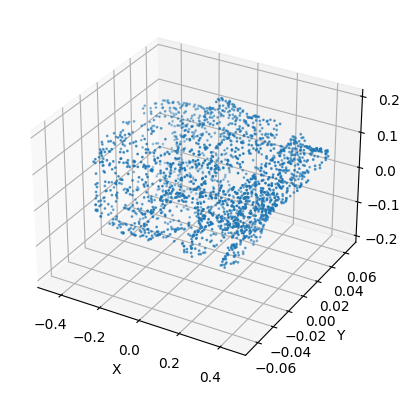

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_point_cloud(point_cloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example usage:
# Visualize a point cloud from the train dataset
example_point_cloud = train_data[150]
visualize_point_cloud(example_point_cloud)

#Auto Encoder

In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PointCloudVariationalAutoencoder(nn.Module):
#     def __init__(self, num_points, latent_dim):
#         super(PointCloudVariationalAutoencoder, self).__init__()
#         self.num_points = num_points
#         self.latent_dim = latent_dim

#         # Encoder
#         self.encoder_conv1 = nn.Conv1d(3, 64, 1)
#         self.encoder_conv2 = nn.Conv1d(64, 128, 1)
#         self.encoder_fc1 = nn.Linear(128 * num_points, 2048)
#         self.encoder_fc2_mean = nn.Linear(2048, latent_dim)
#         self.encoder_fc2_logvar = nn.Linear(2048, latent_dim)

#         # Decoder
#         self.decoder_fc1 = nn.Linear(latent_dim, 2048)
#         self.decoder_fc2 = nn.Linear(2048, 128 * num_points)
#         self.decoder_conv1 = nn.Conv1d(128, 64, 1)
#         self.decoder_conv2 = nn.Conv1d(64, 3, 1)

#         # Upsampling layer for encoder
#         self.upsample = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)

#     def forward(self, x):
#         # Encoder
#         x = F.relu(self.encoder_conv1(x))
#         x = F.relu(self.encoder_conv2(x))
#         if x.size(-1) == 1024:  # Check if input size is 1024
#             x = self.upsample(x)
#         x = x.view(-1, 128 * self.num_points)
#         x = F.relu(self.encoder_fc1(x))
#         z_mean = self.encoder_fc2_mean(x)
#         z_logvar = self.encoder_fc2_logvar(x)

#         # Reparameterization trick
#         epsilon = torch.randn_like(z_logvar)
#         z = z_mean + torch.exp(0.5 * z_logvar) * epsilon

#         # Decoder
#         x = F.relu(self.decoder_fc1(z))
#         x = F.relu(self.decoder_fc2(x))
#         x = x.view(-1, 128, self.num_points)
#         x = F.relu(self.decoder_conv1(x))
#         x = self.decoder_conv2(x)

#         return x, z

#     def get_encoder(self):
#         return Encoder(self.num_points, self.latent_dim)

#     def get_decoder(self):
#         return Decoder()

# class Encoder(nn.Module):
#     def __init__(self, num_points, latent_dim):
#         super(Encoder, self).__init__()
#         self.num_points = num_points
#         self.latent_dim = latent_dim

#         self.encoder_conv1 = nn.Conv1d(3, 64, 1)
#         self.encoder_conv2 = nn.Conv1d(64, 128, 1)
#         self.encoder_fc1 = nn.Linear(128 * num_points, 2048)
#         self.encoder_fc2_mean = nn.Linear(2048, latent_dim)
#         self.encoder_fc2_logvar = nn.Linear(2048, latent_dim)

#         # Upsampling layer for encoder
#         self.upsample = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0)

#     def forward(self, x):
#         x = F.relu(self.encoder_conv1(x))
#         x = F.relu(self.encoder_conv2(x))
#         if x.size(-1) == 1024:  # Check if input size is 1024
#             x = self.upsample(x)
#         x = x.view(-1, 128 * self.num_points)
#         x = F.relu(self.encoder_fc1(x))
#         z_mean = self.encoder_fc2_mean(x)
#         z_logvar = self.encoder_fc2_logvar(x)
#         return z_mean, z_logvar

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.feature_num = 256
#         self.output_point_number = 2048

#         self.linear1 = nn.Linear(self.feature_num, self.output_point_number*2)
#         self.linear2 = nn.Linear(self.output_point_number*2, self.output_point_number*3)
#         self.linear3 = nn.Linear(self.output_point_number*3, self.output_point_number*4)
#         self.linear_out = nn.Linear(self.output_point_number*4, self.output_point_number*3)

#         # Special initialization for linear_out to get a uniform distribution over the space
#         self.linear_out.bias.data.uniform_(-1, 1)

#     def forward(self, x):
#         # Reshape from feature vector NxC to NxC
#         x = F.relu(self.linear1(x))
#         x = F.relu(self.linear2(x))
#         x = F.relu(self.linear3(x))
#         x = self.linear_out(x)

#         return x.view(-1, 3, self.output_point_number)


#### Auto Encoder

In [33]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Define the encoder layers with reduced channel sizes
        self.encoder = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv1: Input (3 channels) -> Output (32 channels)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # Conv2: Input (32 channels) -> Output (64 channels)
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),  # Conv3: Input (64 channels) -> Output (128 channels)
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),  # Conv4: Input (128 channels) -> Output (128 channels)
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),  # Conv5: Input (128 channels) -> Output (256 channels)
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder pass: Input shape [batch_size, 3 (channels), num_points] -> Output shape [batch_size, 256 (channels), num_points]
        encoded = self.encoder(x)
        return encoded


class Decoder(nn.Module):
    def __init__(self, bottleneck_size=256):
        super(Decoder, self).__init__()

        # Define the decoder layers with reduced dimensions
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 1024),  # Linear1: Input (bottleneck_size) -> Output (1024)
            nn.ReLU(),
            nn.Linear(1024, 2048 * 3),  # Linear2: Input (1024) -> Output (2048 * 3)
            nn.ReLU(),
            nn.Linear(2048 * 3, 3)  # Linear3: Input (2048 * 3) -> Output (2048 * 3)
        )

    def forward(self, x):
        # Decoder pass: Input shape [batch_size, 256] -> Output shape [batch_size, 2048 * 3]
        decoded = self.decoder(x)

        # Reshape the decoded tensor to match the desired output shape: [batch_size, 1, 3, 2048]
        decoded = decoded.view(-1, 1, 3, 2048)

        return decoded


class PointCloudAutoEncoder(nn.Module):
    def __init__(self, bottleneck_size=256):
        super(PointCloudAutoEncoder, self).__init__()

        # Instantiate Encoder and Decoder
        self.encoder = Encoder()
        self.decoder = Decoder(bottleneck_size=bottleneck_size)

    def forward(self, x):
        # Encoder pass
        encoded = self.encoder(x)  # Encoded shape: [batch_size, 256 (channels), num_points]

        # Flatten the encoded features for the decoder: reshape to [batch_size, 256]
        encoded_flattened = encoded.view(-1, 256)

        # Decoder pass
        decoded = self.decoder(encoded_flattened)  # Decoded shape: [batch_size, 1, 3, 2048]

        return decoded

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

# Instantiate the PointCloudAutoEncoder
autoencoder = PointCloudAutoEncoder()

# Print the autoencoder architecture
print(autoencoder)


PointCloudAutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=6144, bias=True)
      (3): ReLU()
      (4): Linear(in_features=6144, out_features=3, bias=True)
    )
  )
)


In [34]:
# autoencoder = PointCloudVariationalAutoencoder(num_points=2048, latent_dim=256)
autoencoder = PointCloudAutoEncoder()

#### Training AE and generating GFVs

In [11]:
# !pip install torch-geometric
# !pip install chamfer_distance
!pip install faiss-cpu


In [39]:
import torch
import numpy as np
import faiss
import torch.nn as nn


def robust_norm(var):
    '''
    :param var: Variable of BxCxHxW
    :return: p-norm of BxCxW
    '''
    result = ((var**2).sum(dim=2) + 1e-8).sqrt()
    # result = (var ** 2).sum(dim=2)

    # try to make the points less dense, caused by the backward loss
    # result = result.clamp(min=7e-3, max=None)
    return result

class ChamferLoss(nn.Module):
    def __init__(self, opt):
        super(ChamferLoss, self).__init__()
        self.dimension = 3
        self.k = 1

        # we need only a StandardGpuResources per GPU
        # self.res = faiss.StandardGpuResources()
        # self.res.setTempMemoryFraction(0.1)

        # place holder
        self.forward_loss = torch.FloatTensor([0])
        self.backward_loss = torch.FloatTensor([0])

    def build_nn_index(self, database):
        '''
        :param database: numpy array of Nx3
        :return: Faiss index, in CPU
        '''
        database = np.ascontiguousarray(database)
        index = faiss.IndexFlatL2(self.dimension)
        index.add(database)
        return index

    def search_nn(self, index, query, k):
        '''
        :param index: Faiss index
        :param query: numpy array of Nx3
        :return: D: Variable of Nxk, type FloatTensor, in CPU
                 I: Variable of Nxk, type LongTensor, in CPU
        '''
        D, I = index.search(query, k)

        D_var = torch.from_numpy(np.ascontiguousarray(D))
        I_var = torch.from_numpy(np.ascontiguousarray(I).astype(np.int64))

        return D_var, I_var

    def forward(self, predict_pc, gt_pc):
        '''
        :param predict_pc: Bx3xM Variable in CPU
        :param gt_pc: Bx3xN Variable in CPU
        :return:
        '''
        # for VAE
        # predict_pc = predict_pc[0]
        predict_pc_size = predict_pc.size()
        gt_pc_size = gt_pc.size()

        # print(predict_pc.shape)

        predict_pc_np = np.ascontiguousarray(torch.transpose(predict_pc.data.clone(), 1, 2).numpy())  # BxMx3
        gt_pc_np = np.ascontiguousarray(torch.transpose(gt_pc.data.clone(), 1, 2).numpy())  # BxNx3

        # selected_gt: Bxkx3xM
        selected_gt_by_predict = torch.FloatTensor(predict_pc_size[0], self.k, predict_pc_size[1], predict_pc_size[2])
        # selected_predict: Bxkx3xN
        selected_predict_by_gt = torch.FloatTensor(gt_pc_size[0], self.k, gt_pc_size[1], gt_pc_size[2])

        # print("selected gt by predcit", selected_gt_by_predict.shape)
        # print("selected predict by gt", selected_predict_by_gt.shape)

        # process each batch independently.
        for i in range(predict_pc_np.shape[0]):
            index_predict = self.build_nn_index(predict_pc_np[i])
            index_gt = self.build_nn_index(gt_pc_np[i])

            # database is gt_pc, predict_pc -> gt_pc -----------------------------------------------------------
            _, I_var = self.search_nn(index_gt, predict_pc_np[i], self.k)

            # process nearest k neighbors
            for k in range(self.k):
                selected_gt_by_predict[i,k,...] = gt_pc[i].index_select(1, I_var[:,k])

            # database is predict_pc, gt_pc -> predict_pc -------------------------------------------------------
            _, I_var = self.search_nn(index_predict, gt_pc_np[i], self.k)

            # process nearest k neighbors
            for k in range(self.k):
                selected_predict_by_gt[i,k,...] = predict_pc[i].index_select(1, I_var[:,k])

        # compute loss ===================================================
        # selected_gt(Bxkx3xM) vs predict_pc(Bx3xM)
        forward_loss_element = robust_norm(selected_gt_by_predict-predict_pc.unsqueeze(1).expand_as(selected_gt_by_predict))
        self.forward_loss = forward_loss_element.mean()
        self.forward_loss_array = forward_loss_element.mean(dim=1).mean(dim=1)

        # selected_predict(Bxkx3xN) vs gt_pc(Bx3xN)
        backward_loss_element = robust_norm(selected_predict_by_gt - gt_pc.unsqueeze(1).expand_as(selected_predict_by_gt))  # BxkxN
        self.backward_loss = backward_loss_element.mean()
        self.backward_loss_array = backward_loss_element.mean(dim=1).mean(dim=1)

        # self.loss_array = self.forward_loss_array + self.backward_loss_array
        return self.forward_loss + self.backward_loss

    def __call__(self, predict_pc, gt_pc):
        # start_time = time.time()
        loss = self.forward(predict_pc, gt_pc)
        # print(time.time()-start_time)
        return loss


#### Pdding the data after removing points and reconstructin using Decoder

#### Train Optimize Validate and save the AE model

In [ ]:
# Function to train the autoencoder

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


# Function to validate the autoencoder and save AE model
model_save_path = org_root + 'models/ae_model'
model_save = False



def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

def save_model(model, epoch, best_loss, is_best, model_save_path):
    if model_save:
        save_checkpoint({
            'epoch': epoch + 1,
            'model': 'ae_model',
            'state_dict': model.state_dict(),
            'state_dict_encoder': model.get_encoder().state_dict(),
            'state_dict_decoder': model.get_decoder().state_dict(),
            'best_loss': best_loss
        }, is_best, model_save_path)
        print('Model saved!')

def validate_autoencoder(valid_loader, model, criterion, epoch, model_save_path, loss_threshold):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for i, (input_data) in enumerate(valid_loader):
            trans_data = torch.transpose(input_data, 1, 2)
            output = model(trans_data)
            loss = criterion(output, trans_data)
            total_loss += loss.item() * trans_data.size(0)
        average_loss = total_loss / len(valid_loader.dataset)
        print(f"Validation Loss: {average_loss}")
        if average_loss <= loss_threshold:
          best_loss = average_loss
          save_model(model, epoch, best_loss, True, model_save_path)



def train_autoencoder(train_loader, test_loader, model, criterion, optimizer, model_save_path, num_epochs):
    model.train()
    # print("train loader.....",train_loader.__getitem__(0))
    for epoch in range(num_epochs):
        for input_data in tqdm(train_loader):
            optimizer.zero_grad()
            # input_data = torch.unsqueeze(input_data,dim=0).float()
            # print("input_data.....",input_data.shape)
            trans_data = torch.transpose(input_data, 1, 2)

            output = model(trans_data)
            output = output.squeeze(1).squeeze(0)
            # print("output.....",output.shape)
            loss = criterion(output, trans_data)
            loss.backward()
            optimizer.step()
            # scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

        # Validate the autoencoder
        validate_autoencoder(test_loader, autoencoder, criterion, epoch, model_save_path, loss_threshold = 0.04)



# Example usage
# Assuming train_data, valid_data, and test_data are your training, validation, and test datasets
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
test_loader = DataLoader(test_data, batch_size=50)

# Initialize your autoencoder model
num_points = 2048  # Change this according to your point cloud size
latent_dim = 256 # for VAE
# autoencoder = PointCloudVariationalAutoencoder(num_points, latent_dim)

# Define loss function and optimizer
criterion = ChamferLoss({})
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs


# Train the autoencoder
train_autoencoder(train_loader, test_loader, autoencoder, criterion, optimizer, model_save_path, num_epochs=40)


 23%|██▎       | 7/30 [02:36<08:25, 22.00s/it]

#### Saving the trained model

In [33]:
dir_path = drive_root + '/models/'
model_save_path_enc = dir_path + 'vae_encoder4.pth'
model_save_path_dec = dir_path + 'vae_decoder4.pth'
torch.save(autoencoder.get_encoder().state_dict(), model_save_path_enc)
torch.save(autoencoder.get_decoder().state_dict(), model_save_path_dec)


In [35]:
autoencoder2 = PointCloudVariationalAutoencoder(num_points=2048, latent_dim=256)
drive_root = '/content/drive/MyDrive/RLFinalProjectFiles'
dir_path = drive_root + '/models/'
model_save_path_enc = dir_path + 'vae_encoder4.pth'
model_save_path_dec = dir_path + 'vae_decoder4.pth'

encoder_state_dict = torch.load(model_save_path_enc)
decoder_state_dict = torch.load(model_save_path_dec)
encoder = autoencoder2.get_encoder().load_state_dict(encoder_state_dict)
decoder = autoencoder2.get_decoder().load_state_dict(decoder_state_dict)

#### Testing decoder output for test data(with 50% points)

In [15]:
eval_data = PointCloudDataset(os.path.join(org_root + '_split', 'test', str(50)))

eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)

input_data


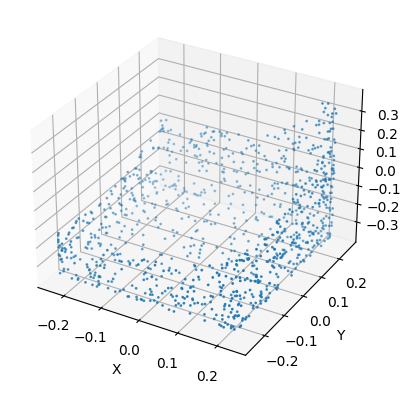

decoded_output


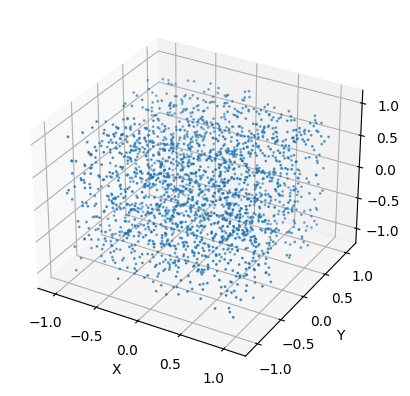

input_data


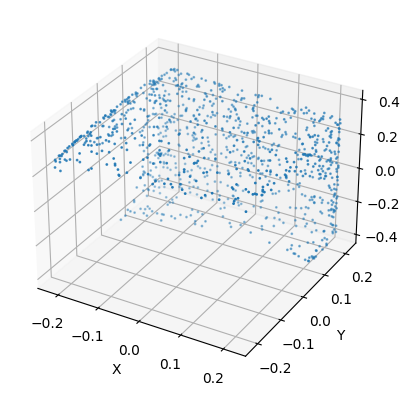

decoded_output


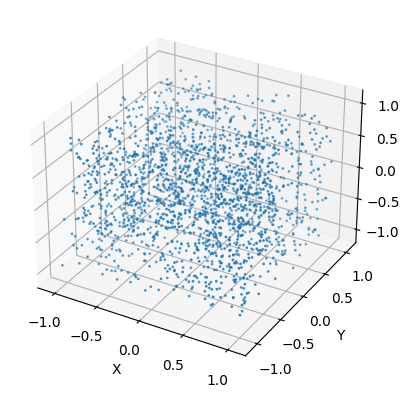

input_data


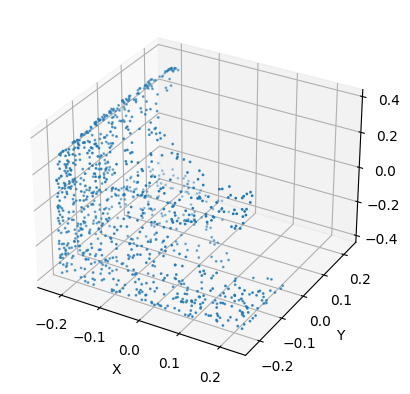

decoded_output


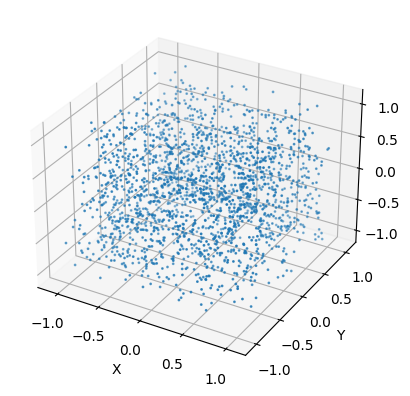

input_data


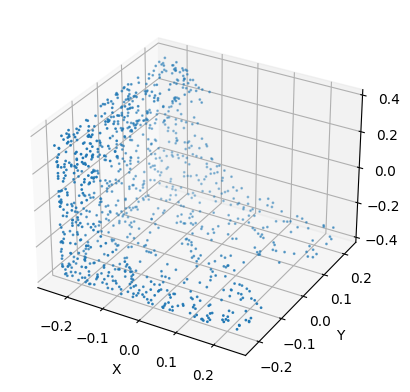

decoded_output


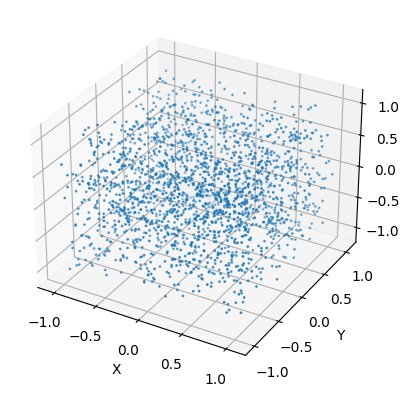

input_data


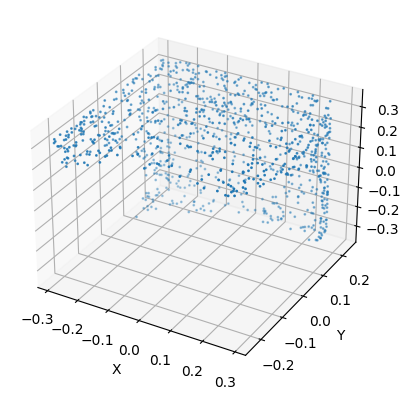

decoded_output


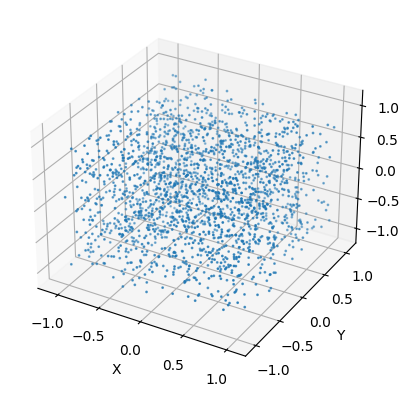

input_data


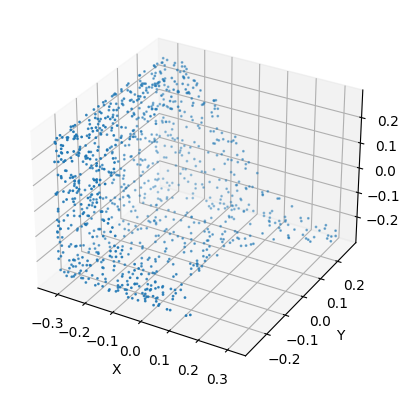

decoded_output


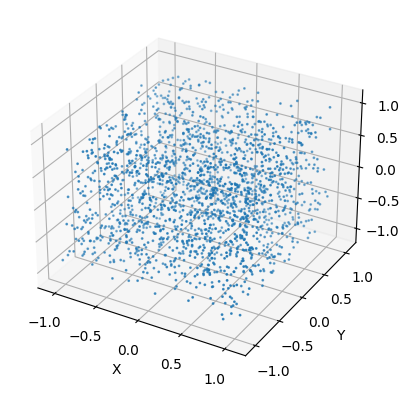

input_data


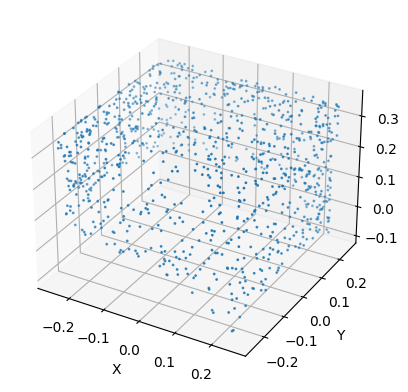

decoded_output


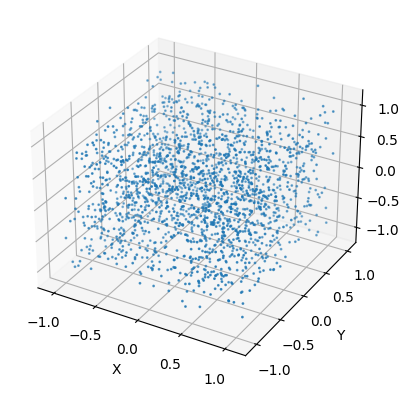

input_data


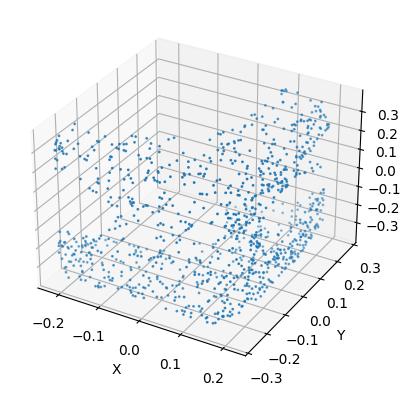

decoded_output


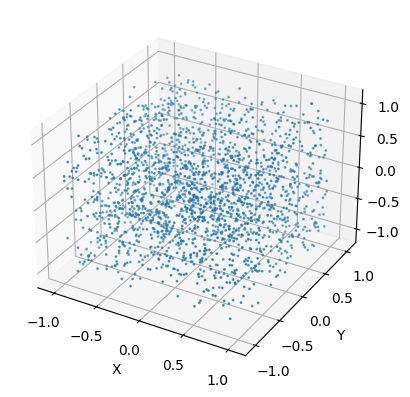

input_data


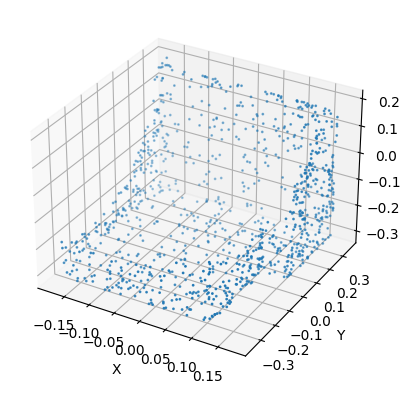

decoded_output


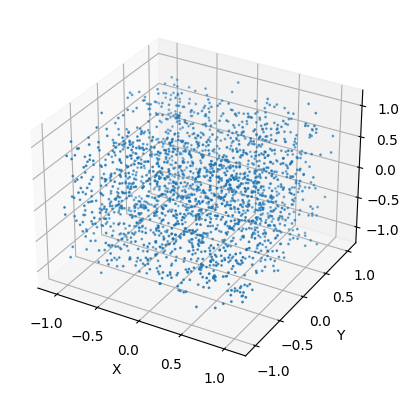

input_data


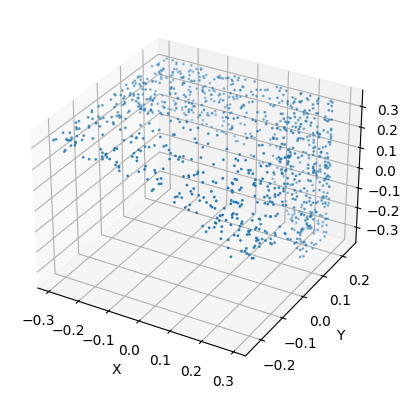

decoded_output


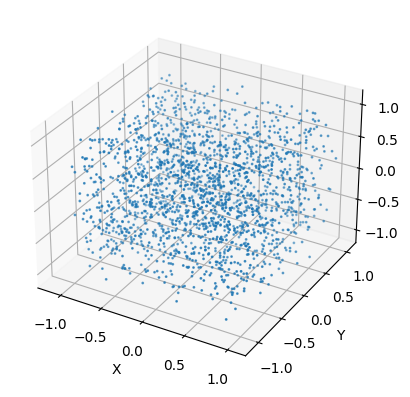

input_data


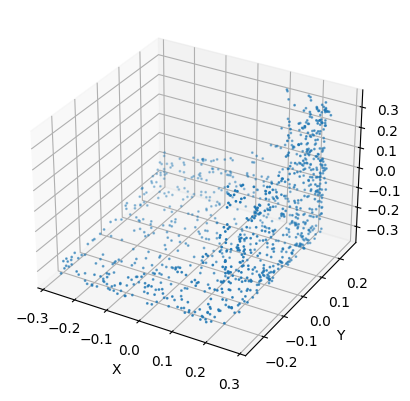

decoded_output


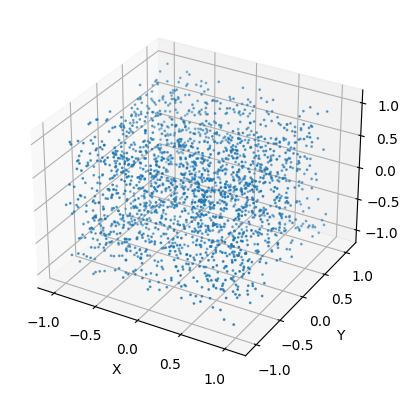

In [16]:

def upsample_point_cloud(input_data, target_points):
    # Reshape input_data to have shape (batch_size, num_channels * num_points)
    input_data_transpose = input_data.transpose(1,2)

    # Use interpolation to upsample the data
    upsampled_data = F.interpolate(input_data_transpose, size=target_points, mode='nearest-exact')

    return upsampled_data


for i, input_data in enumerate(eval_loader):

    # input_data = torch.transpose(input_data, 1, 2)
    print( "input_data")
    visualize_point_cloud(input_data.transpose(1,2))
    input_data = upsample_point_cloud(input_data, 2048)
    encoder_output_mean, encoder_output_logvar = autoencoder.get_encoder()(input_data)

    # Reparameterization trick
    epsilon = torch.randn_like(encoder_output_logvar)
    encoded_output = encoder_output_mean + torch.exp(0.5 * encoder_output_logvar) * epsilon

    # Get the decoder output
    decoded_output = autoencoder.get_decoder()(encoded_output)
    print("decoded_output")
    visualize_point_cloud(decoded_output.detach().numpy())

    if i == 10:
        break


#### Generating and saing GFVs

In [27]:
import numpy as np
from pathlib import Path

def generate_gfvs(train_loader, test_loader, encoder, save_dir):
    encoder.eval()

    Path(save_dir).mkdir(parents=True, exist_ok=True)  # Create save directory if not exists

    # Process train data
    for i, input_data in enumerate(train_loader):
        input_data = torch.transpose(input_data, 1, 2)
        #for VAE
        encoder_output_mean, encoder_output_logvar = autoencoder.get_encoder()(input_data)

        # Reparameterization trick
        epsilon = torch.randn_like(encoder_output_logvar)
        encoded_output = encoder_output_mean + torch.exp(0.5 * encoder_output_logvar) * epsilon
        encoded_output = encoded_output[:, :1024]
        print("gfv shape", encoded_output.shape)
        file_name = f"train_gfv_{i}.npy"
        np.save(save_dir / file_name, encoded_output.detach().cpu().numpy())

    #Process eval data
    for i, input_data in enumerate(eval_loader):
        input_data = upsample_point_cloud(input_data, 2048)
        # input_data = torch.transpose(input_data, 1, 2)
        encoder_output_mean, encoder_output_logvar = autoencoder.get_encoder()(input_data)

        # Reparameterization trick
        epsilon = torch.randn_like(encoder_output_logvar)
        encoded_output = encoder_output_mean + torch.exp(0.5 * encoder_output_logvar) * epsilon
        encoded_output = encoded_output[:, :1024]
        print("gfv shape", encoded_output.shape)
        file_name = f"eval_gfv_{i}.npy"
        np.save(save_dir / file_name, encoded_output.detach().cpu().numpy())

    # Process test data
    for i, input_data in enumerate(test_loader):
        input_data = torch.transpose(input_data, 1, 2)
        encoder_output_mean, encoder_output_logvar = autoencoder.get_encoder()(input_data)

        # Reparameterization trick
        epsilon = torch.randn_like(encoder_output_logvar)
        encoded_output = encoder_output_mean + torch.exp(0.5 * encoder_output_logvar) * epsilon
        encoded_output = encoded_output[:, :1024]
        file_name = f"test_gfv_{i}.npy"
        np.save(save_dir / file_name, encoded_output.detach().cpu().numpy())

    print("Global Feature Vectors saved at:", save_dir)

# Define the save directory for the global feature vectors
gfv_dir_root = drive_root + "/gfv_vae3/50"
save_dir = Path(gfv_dir_root)

# Generate global feature vectors for train and test data using the encoder and save them
generate_gfvs(train_loader, test_loader, autoencoder.get_encoder(), save_dir)



gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([50, 256])
gfv shape torch.Size([25, 256])
gfv shape torch.Size([50, 256])
gfv shap